In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_loading import get_amazon_data
from evaluation import evaluate_policy_on_amazon_new, create_offline_dataset
from policies.linucb import LinUCB
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from sklearn.model_selection import train_test_split

In [94]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names

In [5]:
PROJECT_DIR = '.'

In [57]:
data = get_amazon_data()
actions, action_features, user_stream, user_features, reward_list = data

In [7]:
times = 5000

In [8]:
def plot_ctrs(reward_dict):
    fig, ax = plt.subplots(1,1, figsize=(15, 7));
    
    N = 100
    
    reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, reward in reward_list:
        times = (range(1, len(reward)+1))
        ctr = [r/t for r,t in zip(reward, times)]
        ax.plot(ctr[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('CTR')
    ax.set_title('CTR on Amazon')

    plt.legend();
    plt.show();

In [9]:
linucb_policy = LinUCB(context_dimension=100, alpha=0.8)

seq_reward_linucb = evaluate_policy_on_amazon_new(
    linucb_policy, times, actions, action_features, user_stream, user_features, reward_list
)
print(f"Total reward is {seq_reward_linucb[-1][0]}")


WARNING !!!
Feature flag is ON, using NEW evaluation function

0
1000
2000
3000
4000
Total reward is 1538.0


In [75]:
np.unique(contexts[:, 3])

AttributeError: 'numpy.ndarray' object has no attribute 'len'

In [76]:
from collections import deque
import six

import torch
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr_torch.inputs import SparseFeat, DenseFeat, get_feature_names
from deepctr_torch.models import *

class DeepFM_OnlinePolicy():
    def __init__(self, context_dimension, batch_size=1):
        self.context_dimension = context_dimension
        self.batch_size = batch_size

        self.model = None

        # Save chosen context and action at time t
        self.context_t = None
        self.action_t = None
        # Save last `batch_size` pairs of context and reward to train the model.
        self.context_label_memory = deque(maxlen=batch_size)
    
    def update_memory(self, memory):  # (context_t, reward_t)
        self.context_label_memory.append(memory)
    
    def update_model_params(self):
        if len(self.context_label_memory) < self.batch_size:
            return
        
        dataset = np.zeros(shape=(self.batch_size, self.context_dimension))
        labels = np.zeros(shape=(self.batch_size,))
        for idx, (context_t, reward_t) in enumerate(self.context_label_memory):
            dataset[idx] = context_t
            labels[idx] = reward_t
        
        ### Training on gathered data
        
        sparse_features = []
        dense_features = [i for i in range(self.context_dimension)]

#         dataset[sparse_features] = dataset[sparse_features].fillna('-1', )
#         dataset[dense_features] = dataset[dense_features].fillna(0, )
        target = labels

        # 1.Label Encoding for sparse features,and do simple Transformation for dense features
#         for feat in sparse_features:
#             lbe = LabelEncoder()
#             dataset[feat] = lbe.fit_transform(dataset[feat])
            
        mms = MinMaxScaler(feature_range=(0, 1))
        dataset[:, dense_features] = mms.fit_transform(dataset[:, dense_features])

        # 2.count #unique features for each sparse field,and record dense feature field name

        fixlen_feature_columns = [SparseFeat(feat, len(np.unique(contexts[:, feat])))
                                  for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                                  for feat in dense_features]

        dnn_feature_columns = fixlen_feature_columns
        linear_feature_columns = fixlen_feature_columns

        feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
        
        train_model_input = {feat_id: dataset[:, feat_id] for feat_id in feature_names}

        # 4.Define Model,train,predict and evaluate
        if self.model is None:
            device = 'cpu'
            use_cuda = True
            if use_cuda and torch.cuda.is_available():
                print('cuda ready...')
                device = 'cuda:0'

            self.model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
                           task='binary',
                           l2_reg_embedding=1e-5, device=device)

            self.model.compile("adagrad", "binary_crossentropy",
    #                       metrics=["binary_crossentropy", "auc"], )
                          metrics=[], )
        
        self.model.fit(
            train_model_input,
            target,
            batch_size=self.batch_size,
            epochs=1,
            verbose=2,
            validation_split=0.0
        )
        # Clear the memory
        self.context_label_memory.clear()
        
    def get_score(self, context, trial):
        action_ids = list(six.viewkeys(context))
        context_array = np.asarray([context[action_id] for action_id in action_ids])
        
        # preprocessing for prediction
        sparse_features = []
        dense_features = [i for i in range(self.context_dimension)]

#         dataset[sparse_features] = dataset[sparse_features].fillna('-1', )
#         dataset[dense_features] = dataset[dense_features].fillna(0, )

        # 1.Label Encoding for sparse features,and do simple Transformation for dense features
#         for feat in sparse_features:
#             lbe = LabelEncoder()
#             dataset[feat] = lbe.fit_transform(dataset[feat])
            
        mms = MinMaxScaler(feature_range=(0, 1))
        context_array[:, dense_features] = mms.fit_transform(context_array[:, dense_features])

        # 2.count #unique features for each sparse field,and record dense feature field name

        fixlen_feature_columns = [SparseFeat(feat, dataset[feat].nunique())
                                  for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                                  for feat in dense_features]
        dnn_feature_columns = fixlen_feature_columns
        linear_feature_columns = fixlen_feature_columns
        feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
        model_input = {feat_id: context_array[:, feat_id] for feat_id in feature_names}
        
        if self.model is None:
#             estimated_ctr_array = np.ones(context_array.shape[1])
            estimated_ctr_array = np.random.uniform(low=0.0, high=1.0, size=context_array.shape[1])
        else:
            estimated_ctr_array = self.model.predict(model_input, batch_size=len(action_ids))
        
        score_dict = {}
        for action_id, ctr in zip(action_ids, estimated_ctr_array):
            score_dict[action_id] = float(ctr)

        return score_dict
        
    def get_action(self, context, trial):
        
        score = self.get_score(context, trial)
        recommendation_id = max(score, key=score.get)
        self.full_context_t = context
        self.action_t = recommendation_id
        return recommendation_id
        
    
    def reward(self, reward_t):
        context_t = self.full_context_t[self.action_t]
        self.update_memory((context_t, reward_t))
        self.update_model_params()


In [77]:
deep_fm_policy = DeepFM_OnlinePolicy(context_dimension=100, batch_size=times+1)

In [29]:
seq_reward_deep_fm = evaluate_policy_on_amazon_new(
    deep_fm_policy, times, actions, action_features, user_stream, user_features, reward_list
)
print(f"Total reward is {seq_reward_deep_fm[-1][0]}")


WARNING !!!
Feature flag is ON, using NEW evaluation function

0
1000
2000
3000
4000
Total reward is 43.0


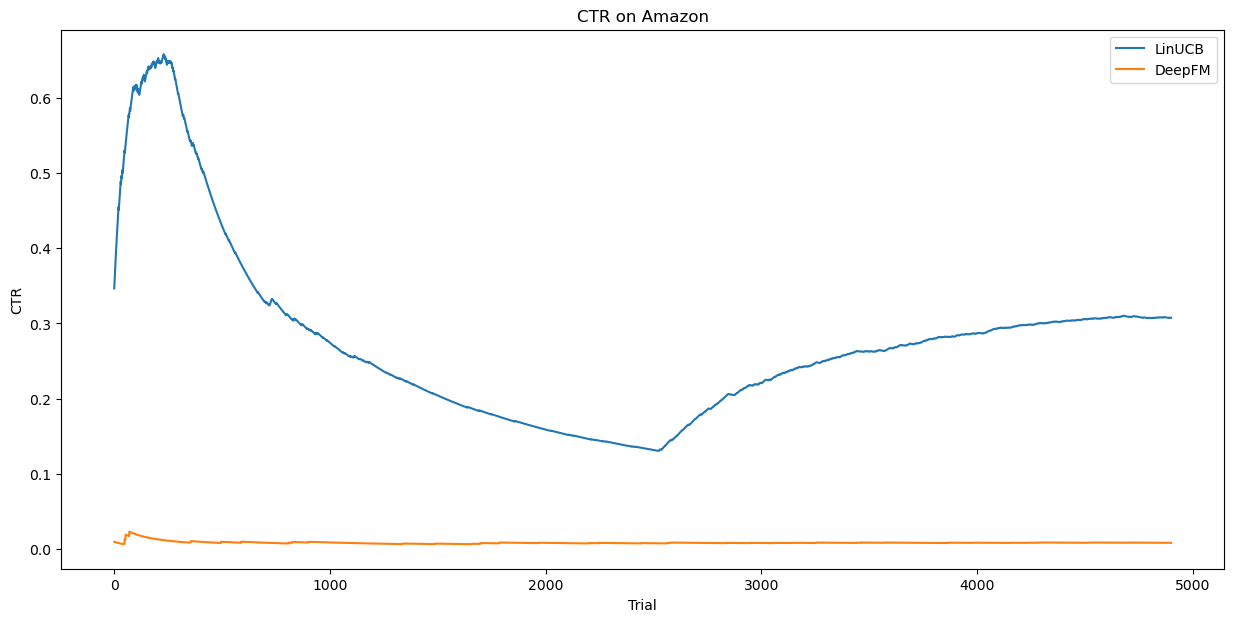

In [30]:
plot_ctrs(
    {
        'DeepFM': seq_reward_deep_fm,
        'LinUCB': seq_reward_linucb,
        
    }
)

In [31]:
deep_fm_policy.context_label_memory

deque([(array([-0.10566277, -0.08127002,  0.02429484, -0.06938623, -0.06351335,
                0.10595639,  0.22466293, -0.09591689, -0.11504335,  0.17522371,
               -0.17715296,  0.08187339, -0.06457778,  0.10761948, -0.07657264,
               -0.22158553, -0.03530791,  0.21064777, -0.00550361,  0.22735435,
                0.01676958, -0.08871728, -0.15224131,  0.01118072, -0.13157489,
               -0.19157357, -0.1362237 ,  0.01847235, -0.20892888, -0.09068387,
               -0.06406188,  0.0304429 , -0.04228695, -0.05249083,  0.03501551,
                0.00604435, -0.1004025 ,  0.19152782,  0.05497603,  0.07155252,
               -0.08759926,  0.02126115,  0.12577099,  0.0425347 , -0.02673072,
                0.26562148,  0.24830257, -0.23097807,  0.02380502,  0.173859  ,
               -0.0307621 ,  0.01243542,  0.09934682,  0.0564268 , -0.02392342,
               -0.08514023, -0.03996404,  0.12010084, -0.07329706,  0.10334934,
               -0.05299096,  0.03262309,

In [33]:
dataset = np.zeros(shape=(times+1, 100))
labels = np.zeros(shape=(times+1,))
for idx, (context_t, reward_t) in enumerate(deep_fm_policy.context_label_memory):
    dataset[idx] = context_t
    labels[idx] = reward_t

In [34]:
dataset.shape

(5001, 100)

In [36]:
sum(labels)

43.0

In [38]:
dataset.shape

(5001, 100)

## Create an offline dataset from the same data

In [64]:
contexts, rewards = create_offline_dataset(
    times, actions, action_features, user_stream, user_features, reward_list
)

0
1000
2000
3000
4000


In [87]:
sparse_features = [str(i) for i in range(contexts.shape[1])]
dense_features = [str(i) for i in range(contexts.shape[1])]

# data[sparse_features] = data[sparse_features].fillna('-1', )
# data[dense_features] = data[dense_features].fillna(0, )

# 1.Label Encoding for sparse features,and do simple Transformation for dense features
for feat in sparse_features:
    lbe = LabelEncoder()
    contexts[:, int(feat)] = lbe.fit_transform(contexts[:, int(feat)])
mms = MinMaxScaler(feature_range=(0, 1))
contexts[:, list(map(int, dense_features))] = mms.fit_transform(contexts[:, list(map(int, dense_features))])

# 2.count #unique features for each sparse field,and record dense feature field name

fixlen_feature_columns = [SparseFeat(feat, len(np.unique(contexts[:, int(feat)])))
                          for feat in sparse_features] + [DenseFeat(feat, 1, )
                                                          for feat in dense_features]

dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns

feature_names = get_feature_names(
    linear_feature_columns + dnn_feature_columns
)

# 3.generate input data for model

x_train, x_test, y_train, y_test = train_test_split(contexts, rewards, test_size=0.2)

train_model_input = {name: x_train[:, int(name)] for name in feature_names}
test_model_input = {name: x_test[:, int(name)] for name in feature_names}

# 4.Define Model,train,predict and evaluate

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'
else:
    print("using cpu")

model = DeepFM(linear_feature_columns=linear_feature_columns, dnn_feature_columns=dnn_feature_columns,
               task='binary',
               l2_reg_embedding=1e-5, device=device)

model.compile("adagrad", "binary_crossentropy",
              metrics=["accuracy"], )
model.fit(train_model_input, y_train, batch_size=32,epochs=10,verbose=2,validation_split=0.0)

pred_ans = model.predict(test_model_input, 256)
print("")
print("test LogLoss", round(log_loss(y_test, pred_ans), 4))
print("test AUC", round(roc_auc_score(y_test, pred_ans), 4))

cpu
Train on 400000 samples, validate on 0 samples, 12500 steps per epoch
Epoch 1/10
146s - loss:  0.0406 - accuracy:  0.9887
Epoch 2/10
137s - loss:  0.0377 - accuracy:  0.9887
Epoch 3/10
153s - loss:  0.0373 - accuracy:  0.9887
Epoch 4/10
143s - loss:  0.0370 - accuracy:  0.9887
Epoch 5/10
154s - loss:  0.0369 - accuracy:  0.9887
Epoch 6/10
139s - loss:  0.0367 - accuracy:  0.9887
Epoch 7/10
134s - loss:  0.0366 - accuracy:  0.9887
Epoch 8/10
142s - loss:  0.0365 - accuracy:  0.9887
Epoch 9/10
138s - loss:  0.0364 - accuracy:  0.9887
Epoch 10/10
140s - loss:  0.0363 - accuracy:  0.9887



NameError: name 'log_loss' is not defined

In [91]:
print("test LogLoss", round(log_loss(y_test, pred_ans), 4))

test LogLoss 0.0382


In [92]:
print("test AUC", round(roc_auc_score(y_test, pred_ans), 4))

test AUC 0.9428


In [103]:
print("test Accuracy", round(accuracy_score(y_test, np.where(pred_ans > 0.5, 1, 0)), 4))

test Accuracy 0.9883
